In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import scipy
from scipy.stats import binned_statistic_2d
from sklearn import cross_validation, datasets, linear_model, metrics
#import mlpy
#import statsmodels.formula.api as smf
#import statsmodels.stats.api as sms
#from statsmodels.graphics.regressionplots import plot_leverage_resid2
%matplotlib inline
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [6]:
dates = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

cols_to_use = ['tpep_pickup_datetime', 
               'tpep_dropoff_datetime',
               'passenger_count',
               'trip_distance',
               'pickup_longitude', 
               'pickup_latitude',
               #'dropoff_longitude',
               #'dropoff_latitude'
              ]

files = [
        'TaxiData/yellow_tripdata_2016-06.csv', 
        'TaxiData/yellow_tripdata_2016-05.csv', 
        'TaxiData/yellow_tripdata_2016-04.csv', 
        'TaxiData/yellow_tripdata_2016-03.csv', 
        'TaxiData/yellow_tripdata_2016-02.csv', 
        'TaxiData/yellow_tripdata_2016-01.csv', 
        #'TaxiData/yellow_tripdata_2015-12.csv', 
        #'TaxiData/yellow_tripdata_2015-11.csv', 
        #'TaxiData/yellow_tripdata_2015-10.csv', 
        #'TaxiData/yellow_tripdata_2015-09.csv', 
        #'TaxiData/yellow_tripdata_2015-08.csv', 
        #'TaxiData/yellow_tripdata_2015-07.csv', 
        #'TaxiData/yellow_tripdata_2015-06.csv', 
        #'TaxiData/yellow_tripdata_2015-05.csv', 
        #'TaxiData/yellow_tripdata_2015-04.csv', 
        #'TaxiData/yellow_tripdata_2015-03.csv', 
        #'TaxiData/yellow_tripdata_2015-02.csv', 
        #'TaxiData/yellow_tripdata_2015-01.csv'
        ]

data = pd.DataFrame()

for f in files:
    print 'Reading ', f
    f_frame = pd.read_csv(f, delimiter=',', usecols=cols_to_use, parse_dates=dates)
    print 'Read frame of shape ', f_frame.shape
    data = pd.concat([data, f_frame])
    del f_frame
    print 'Total ', data.shape, '\r\n'

Reading  TaxiData/yellow_tripdata_2016-06.csv
Read frame of shape  (11135470, 6)
Total  (11135470, 6) 

Reading  TaxiData/yellow_tripdata_2016-05.csv
Read frame of shape  (11836853, 6)
Total  (22972323, 6) 

Reading  TaxiData/yellow_tripdata_2016-04.csv
Read frame of shape  (11934338, 6)
Total  (34906661, 6) 

Reading  TaxiData/yellow_tripdata_2016-03.csv
Read frame of shape  (12210952, 6)
Total  (47117613, 6) 

Reading  TaxiData/yellow_tripdata_2016-02.csv
Read frame of shape  (11382049, 6)
Total  (58499662, 6) 

Reading  TaxiData/yellow_tripdata_2016-01.csv
Read frame of shape  (10906858, 6)
Total  (69406520, 6) 



In [7]:
#На всякий случай проверяем пустые значения
print data.isnull().values.any()

#Задаем границы 
long_min = -74.25559
long_max = -73.70001 
lat_min = 40.49612
lat_max = 40.91553

#Фильтруем данные по границам, длительности, кол-ву пассажиров, длине поездки.
zero_delta = datetime.timedelta(seconds=0)

data = data[((data.tpep_dropoff_datetime - data.tpep_pickup_datetime) > zero_delta) 
                     & (data.passenger_count > 0) 
                     & (data.trip_distance > 0)
                     & (long_min <= data.pickup_longitude)
                     & (data.pickup_longitude <= long_max)
                     & (lat_min <= data.pickup_latitude)
                     & (data.pickup_latitude <= lat_max)
             ]

data.shape

False


(68057766, 6)

In [8]:
#data.to_hdf
#data = data.drop(['dropoff_latitude', 'dropoff_longitude'], axis=1)
#print data.shape
#rint pd.__version__

In [9]:
%%time
#Получаем регионы для каждой поездки (в виде индексов бинов по двум осям)
stat, x_edge , y_edge, binnumber = binned_statistic_2d(data.pickup_longitude, 
                                                       data.pickup_latitude, 
                                                       None,
                                                       statistic='count',
                                                       bins=50, 
                                                       range=[[long_min, long_max], [lat_min, lat_max]],
                                                       expand_binnumbers=True,)

Wall time: 20.7 s


In [10]:
#%%time
#Записываем регионы для каждой позедки в виде одномерного индекса по формуле (x - 1) * 50 + y
data['region'] = (binnumber[0] - 1) * 50 + binnumber[1]

In [11]:
data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,region
0,2016-06-09 21:06:36,2016-06-09 21:13:08,2,0.79,-73.983360,40.760937,1232
1,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1229
2,2016-06-09 21:06:36,2016-06-09 21:13:10,1,1.26,-73.994316,40.751072,1181
3,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1234
4,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.10,-73.987106,40.733173,1229


In [12]:
#Окргугляем время начала поздки до часа 
data.loc[:,'tpep_pickup_datetime'] = data.tpep_pickup_datetime.dt.floor('h')
data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,region
0,2016-06-09 21:00:00,2016-06-09 21:13:08,2,0.79,-73.983360,40.760937,1232
1,2016-06-09 21:00:00,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1229
2,2016-06-09 21:00:00,2016-06-09 21:13:10,1,1.26,-73.994316,40.751072,1181
3,2016-06-09 21:00:00,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1234
4,2016-06-09 21:00:00,2016-06-09 21:23:23,1,3.10,-73.987106,40.733173,1229


In [13]:
#Получаем аггрегированные данные (время, регион, кол-во поездок) - без учета пар время-регион где не было поездок.
data = data.groupby([data.tpep_pickup_datetime, data.region]).size().reset_index(name='count')
data.head()

,tpep_pickup_datetime,region,count
0,2016-01-01,718,1
1,2016-01-01,864,1
2,2016-01-01,928,1
3,2016-01-01,979,1
4,2016-01-01,1015,2


In [15]:
times = data.tpep_pickup_datetime.unique()
#times.sort_values()
#d = times - np.roll(times,1)
#print datetime.timedelta(milliseconds=3600000000000 / (10 ** 6))

start_date = times.min()
day_count = pd.to_timedelta([(times.max() - times.min())]).astype('timedelta64[h]')[0] #.astype('timedelta64[h]').astype('int')
print start_date, times.max(),  day_count.astype('int')
print type(start_date)
print type(datetime.timedelta(hours=12))
dts = [start_date + np.timedelta64(n, 'h') for n in range(day_count)]
print len(dts)


2016-01-01T00:00:00.000000000 2016-06-30T23:00:00.000000000 4367
<type 'numpy.datetime64'>
<type 'datetime.timedelta'>
4367


In [16]:
#Теперь дополним фрейм строками для тех пар время-регион для которых не было поездок.

#Для этого возьмем все возможные времена начала поздки
times = dts# data.tpep_pickup_datetime.unique()
print len(times)
#Создадим фрейм из всех кобинаций регионов и часов
all_regions = range(1,2501)

placeholder = pd.MultiIndex.from_product([times, all_regions], names=['tpep_pickup_datetime','region']).to_frame()
placeholder.reset_index(drop=True, inplace=True)

4367


In [17]:
#Джоиним два фрейма и после заполням нулями ячейки для пар в которых не было поездок
data = pd.merge(data, placeholder, 'right', on=['tpep_pickup_datetime', 'region'])
data = data.fillna(0)
data.head()

,tpep_pickup_datetime,region,count
0,2016-01-01,718,1.0
1,2016-01-01,864,1.0
2,2016-01-01,928,1.0
3,2016-01-01,979,1.0
4,2016-01-01,1015,2.0


In [20]:
pivot_data = data.pivot_table(index='tpep_pickup_datetime',columns='region', values='count')
pivot_data.columns = pivot_data.columns.values
print pivot_data.shape
pivot_data.head()
pivot_data.to_pickle('TaxiData/stat_pivot_2016-01_2016-06.dat')

#data.to_pickle('TaxiData\stat_2016-01_2016-06.dat')
#data = pd.read_pickle('TaxiData\stat_2015-01_2016-04.dat')
#data.shape

(4367, 2500)


,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
#data_s = data.sort_values(['tpep_pickup_datetime'])

#diff = pd.DataFrame(data_s.tpep_pickup_datetime - data_s.tpep_pickup_datetime.shift(1))
#diff = diff.rename(index=str, columns={"tpep_pickup_datetime": "dif"})
#diff[diff.dif != '01:00:00']
#data = data.set_index('tpep_pickup_datetime')

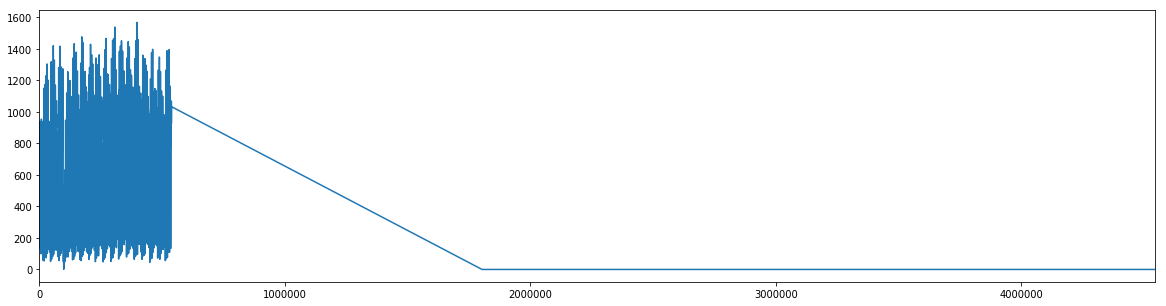

In [59]:
data[data.region == 1231]['count'].plot()

In [16]:
sored_vals = data.groupby(['region']).sum().reset_index().sort_values('count')
sored_vals = sored_vals[sored_vals['count'] < 903962.0]

#sored_vals

In [67]:
#Получаем данные для региона 1231 - Empire State Building (из второй недели)
plt.figure(figsize(20,5))

esb_data = data[data.region == 1326]#1126

print esb_data.shape #(3637, 3) если не дополнять данные пустыми парами
#esb_data = esb_data.sort_values(['tpep_pickup_datetime'])
esb_data.head()

#Пронумеруем строки
#esb_data.to_pickle('TaxiData\stat_2016-01_2016-04_1326.dat')
#esb_data.to_csv('TaxiData\c6w3_esb_data.csv',header=True)
#esb_data = pd.read_pickle('TaxiData\stat_2015-01_2016-04_1126.dat')

(2903, 3)


,tpep_pickup_datetime,region,count
90,2016-01-01 00:00:00,1326,103.0
396,2016-01-01 01:00:00,1326,153.0
743,2016-01-01 02:00:00,1326,167.0
1101,2016-01-01 03:00:00,1326,168.0
1466,2016-01-01 04:00:00,1326,121.0


In [23]:
esb_data_s = esb_data#pd.read_pickle('TaxiData\c6w3_esb_data.dat')
esb_data_s['rn'] =  range(1, esb_data_s.shape[0] + 1)
esb_data_s.head()

C:\Users\nlavr\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,region,count,rn
tpep_pickup_datetime,,,
2016-01-01 00:00:00,1126,319.0,1
2016-01-01 01:00:00,1126,404.0,2
2016-01-01 02:00:00,1126,393.0,3
2016-01-01 03:00:00,1126,252.0,4
2016-01-01 04:00:00,1126,145.0,5


In [ ]:
diff = pd.DataFrame(data.tpep_pickup_datetime - data.tpep_pickup_datetime.shift(1))
diff = diff.rename(index=str, columns={"tpep_pickup_datetime": "dif"})
diff[diff.dif != '01:00:00']

diff[('2015-01-26 00:00:00' < diff.index) & (diff.index < '2015-01-27 08:00:00')  ]

In [25]:
K = 5

for k in range(1, K + 1):
    esb_data_s.loc[:,'s'+ str(k)] = np.sin(esb_data_s['rn'] * 2 * np.pi * k / 168)
    esb_data_s.loc[:,'c'+ str(k)] = np.cos(esb_data_s['rn'] * 2 * np.pi * k / 168)

C:\Users\nlavr\Anaconda2\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\nlavr\Anaconda2\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
esb_data_s.head()

,tpep_pickup_datetime,region,count,rn,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5
22,2015-01-01 00:00:00,1126,305.0,1,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566
313,2015-01-01 01:00:00,1126,474.0,2,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874
647,2015-01-01 02:00:00,1126,372.0,3,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724
994,2015-01-01 03:00:00,1126,325.0,4,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052
1355,2015-01-01 04:00:00,1126,172.0,5,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820


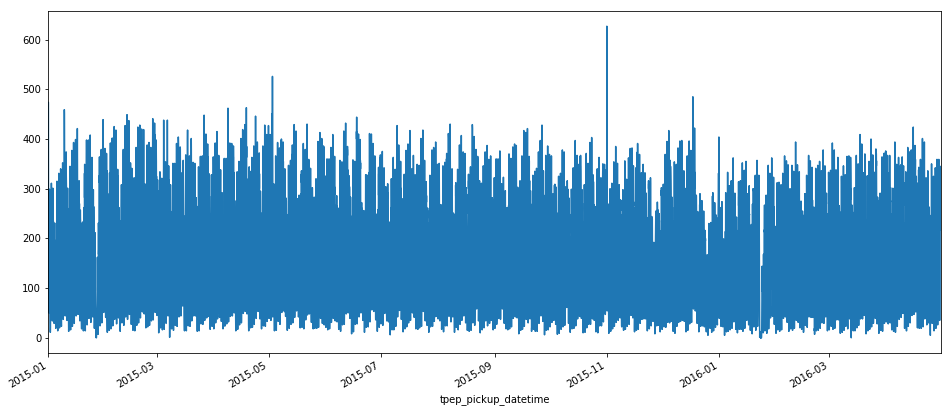

In [27]:
e_data = esb_data_s.set_index(esb_data_s['tpep_pickup_datetime'])
plt.figure(figsize(16,7))
#e_data['count'].plot()
s_data = e_data#[(e_data['tpep_pickup_datetime'] >'2015-02-01 00:00:00') & (e_data['tpep_pickup_datetime'] <'2015-03-01 00:00:00')]
s_data['count'].plot()

In [29]:
x_names = []
for k in range(1, K + 1):
    x_names.append('s'+ str(k))
    x_names.append('c'+ str(k))

train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(
                                                        s_data[x_names], s_data['count'], test_size = 0.2)

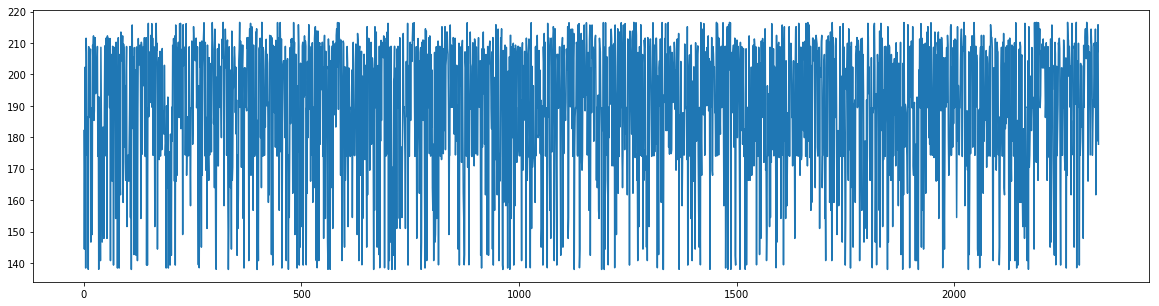

In [30]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(train_data, train_labels)
predictions = linear_regressor.predict(test_data)
plt.plot(predictions)


In [31]:
metrics.mean_absolute_error(test_labels, predictions)

80.683835321290431

In [32]:
linear_scoring = cross_validation.cross_val_score(linear_regressor,  s_data[x_names], s_data['count'], 
                                                  scoring = 'mean_absolute_error', cv = 10)
print 'mean: {}, std: {}'.format(linear_scoring.mean(), linear_scoring.std())

mean: -81.7087207996, std: 3.62593996846


C:\Users\nlavr\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\nlavr\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\nlavr\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\nlavr\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\nlavr\Anaconda2

In [41]:
rs = []
for k in range(1, K + 1):
    rs.append('s'+ str(k))
    rs.append('c'+ str(k))

print str.join(' + ', rs)

m1 = smf.ols('count ~ ' + str.join(' + ', x_names), data=s_data)
fitted = m1.fit()
print fitted.summary()

s1 + c1 + s2 + c2 + s3 + c3 + s4 + c4 + s5 + c5
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     56.21
Date:                Fri, 20 Apr 2018   Prob (F-statistic):          1.34e-111
Time:                        14:14:11   Log-Likelihood:                -70062.
No. Observations:               11664   AIC:                         1.401e+05
Df Residuals:                   11653   BIC:                         1.402e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inte

In [42]:
predictions = fitted.predict(test_data)
metrics.mean_absolute_error(test_labels, predictions)

80.462167709089329

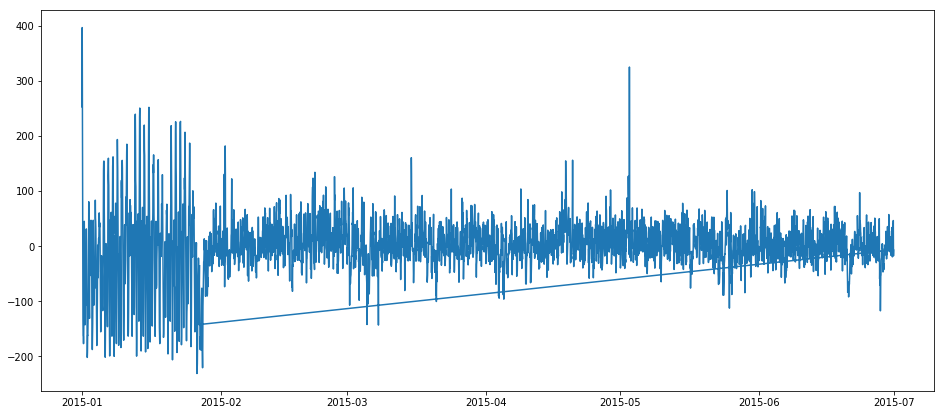

In [84]:
plt.plot(fitted.resid)